Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           multiple                  1600      
_________________________________________________________________
conv2d_78 (Conv2D)           multiple                  520       
Total params: 2,120
Trainable params: 2,120
Non-trainable params: 0
_________________________________________________________________


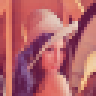

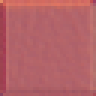


 step: 200, log10(loss): -1.617

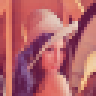

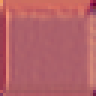


 step: 400, log10(loss): -1.655

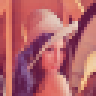

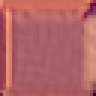


 step: 600, log10(loss): -1.688

KeyboardInterrupt: 

In [42]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import PIL.Image
import IPython.display
import io
import random
import statistics as stats
from matplotlib import pyplot as plt

class CellularAutomata(tf.keras.Model):
    def __init__(self, img_size: int, channel_count: int, layer_size: int):
        super().__init__()
        
        self.img_size = img_size
        self.channel_count = channel_count
        self.conserve_mass = False
        self.noise = 0.0
        self.clamp_values = True
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters = layer_size, kernel_size = 1, 
                activation = tf.nn.relu),
            tf.keras.layers.Conv2D(filters = channel_count, kernel_size = 1, 
                activation = None, kernel_initializer = tf.zeros_initializer)
        ])

        # Compile the model by making a call to it.
        self(tf.zeros([1, 3, 3, channel_count]))
        
    @tf.function
    def perceive(self, x):
        # Create a Sobel filter:
        identity = np.float32([0, 1, 0])
        identity = np.outer(identity, identity)
        dx = np.outer(np.float32([1, 2, 1]), np.float32([-1, 0, 1])) / 8.0
        dy = dx.T

        kernel = tf.stack(
            values = [identity, dx - dy, dx + dy],
            axis = -1)[:, :, None, :] # TODO: figure out what this does

        kernel = tf.repeat(
            input = kernel, 
            repeats = self.channel_count, 
            axis = 2)
        
        return tf.nn.depthwise_conv2d(
            input = x, 
            filter = kernel, 
            strides = [1, 1, 1, 1],
            padding = "SAME")
    
    @tf.function
    def call(self, x):
        s = self.perceive(x)
        dx = self.model(s)
        
        # Add mass conservation to the model by subtracting the average of the dx values.
        if self.conserve_mass:
            dx -= tf.math.reduce_mean(dx)
        x += dx
        
        # Add random noise.
        x += (tf.cast(tf.random.uniform(tf.shape(x[:, :, :, :])), tf.float32) - 0.5) * 2.0 * self.noise
        
        # Keep random noise or changes in dx from causing out-of-range values.
        if self.clamp_values:
            x = tf.clip_by_value(x, 0.0, 1.0)
            
        return x

    def imagefilled(self, image_path):
        """ Fills the world with image data from the disk. """
        x = self.zerofilled()
        img = PIL.Image.open(image_path).convert("RGB")
        color_arr = np.float32(img) / 255.0
        x[:, :, :3] = color_arr
        return x

    def zerofilled(self):
        """ Fills the world with zeros. """
        return np.zeros((self.img_size, self.img_size, self.channel_count), dtype=np.float32)

    def onefilled(self):
        """ Fills the world with ones. """
        return np.ones((self.img_size, self.img_size, self.channel_count), dtype=np.float32)
        
    def pointfilled(self):
        """ Fills the world with zeros except for a single point. """
        x = np.zeros((self.img_size, self.img_size, self.channel_count), dtype=np.float32)
        x[self.img_size // 2, self.img_size // 2] = np.ones((self.channel_count,))
        return x
    
    def randomfilled(self):
        """ Fills the world with random numbers from 0 to 1. """
        x = np.random.rand(self.img_size, self.img_size, self.channel_count).astype(np.float32)
        return x
        
    def to_image(self, x, scale=1):
        # Slice off all the non-color (hidden channels):
        arr = x[..., :3]
        rgb_array = np.uint8(arr * 255.0)

        # Scale the first two dimensions of the image by the given scale.
        for dim in range(2):
            rgb_array = np.repeat(rgb_array, scale, dim)

        out = io.BytesIO()
        PIL.Image.fromarray(rgb_array).save(out, 'png')
        return IPython.display.Image(data=out.getvalue())

    def display(self, x, scale=3):
        IPython.display.display(self.to_image(x, scale))
        
class Training(object):
    def __init__(self, ca, target_img, learning_rate, ca_lifetime):
        self.ca = ca
        self.target = ca.imagefilled(target_img)[..., :3]

        self.ca_lifetime = ca_lifetime
        self.loss_hist = []
        self.learning_rate = learning_rate
        self.lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries = [2000], 
            values = [self.learning_rate, self.learning_rate * 0.1])
        self.trainer = tf.keras.optimizers.Adam(self.lr_sched)
        
    def get_loss(self, x):
        return tf.reduce_mean(tf.square(x[..., :3] - self.target))
    
    def get_sum(self, x):
        return tf.reduce_sum(x)
    
    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as g:
            for i in tf.range(self.ca_lifetime):
                x = self.ca(x)
            loss = tf.reduce_mean(self.get_loss(x))
            
        grads = g.gradient(loss, self.ca.weights)
        grads = [g / (tf.norm(g) + 1.0e-8) for g in grads]
        self.trainer.apply_gradients(zip(grads, self.ca.weights))
        return x, loss
        
    def show_status(self):
        self.ca.display(self.target)
            
        # Run the CA for its lifetime with the current weights.
        x = self.ca.randomfilled()[None, ...]
        for i in range(self.ca_lifetime):
            x = self.ca(x)
        self.ca.display(x[0, ..., :3])
        
        print("\n step: %d, log10(loss): %.3f" % (
            len(self.loss_hist), np.log10(self.loss_hist[-1])), end='')
    
    def run(self, num_steps, batch_size = 1):
        initial = result = loss = None
        assert num_steps > 0
        for i in range(num_steps):
            initial = np.repeat(self.ca.randomfilled()[None, ...], batch_size, 0)
            x, loss = self.train_step(initial)
            self.loss_hist.append(loss.numpy())
        
ca = CellularAutomata(img_size=32, channel_count=8, layer_size=64)
ca.noise = 0.0

ca.model.summary()

training = Training(ca=ca, target_img="lenna32.png", learning_rate=1e-3, ca_lifetime=10)
while True:
    training.run(num_steps = 200)
    training.show_status()